# Red Wine Decision Tree

# Introduction
In this notebook we import the Red Wine dataset https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

We import training data, pre-process, train with Decision Tree Classification, and visualise.

## References and Sources
* Extensive use of sklearn documentation
* No extensive use of 3rd party code

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['figure.figsize'] = [16, 9]

## Import the data and examine

In [2]:
df = pd.read_csv('./winequality-red.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [5]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

### Check for NaNs

In [6]:
df.isnull().values.any()

False

### Check for Duplicates

In [7]:
extra = df[df.duplicated(keep='first')]
print(f'{extra.shape} duplicates')

(240, 12) duplicates


In [8]:
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(1599, 12)
(1359, 12)


### Commentary
We identified 240 duplicates and removed them. There are no NaNs.

In [9]:
df.keys()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Plot Data Distributions

### Print some boxplots to check for outliers, normalising each variable such that the mean = 1 to show on same plot range

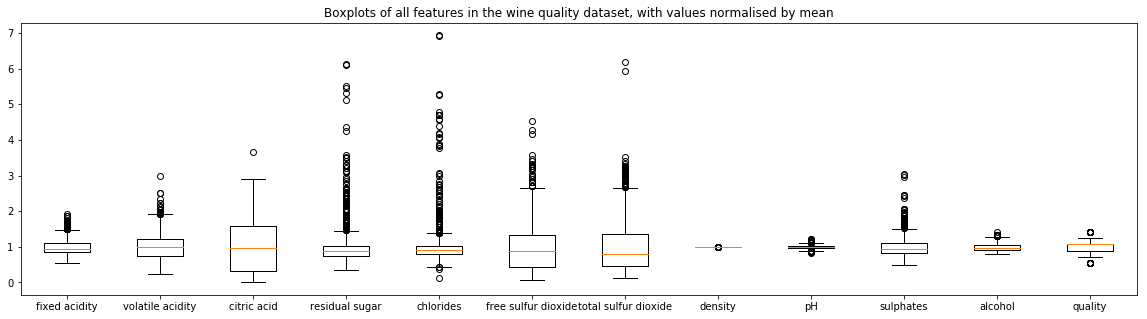

In [10]:
plt.figure(figsize = (20,5))
plt.boxplot([df[i]/df[i].mean() for i in df.keys()], labels = df.keys())
plt.title("Boxplots of all features in the wine quality dataset, with values normalised by mean")
plt.show()

### Commentary
There's a wide range of data but no obvious outliers

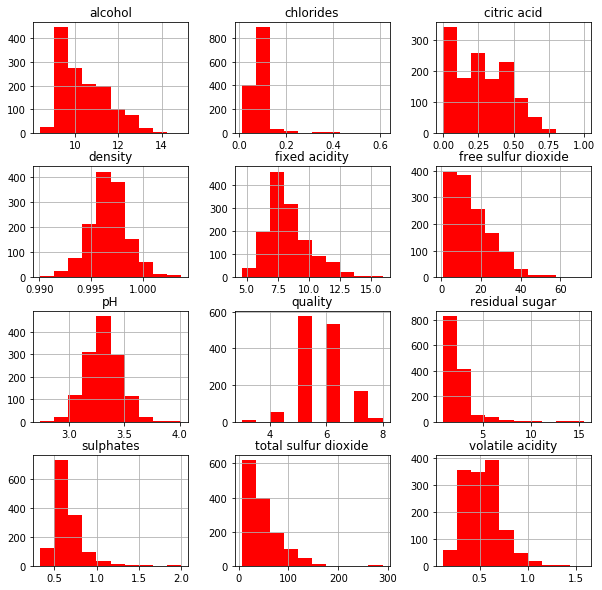

In [11]:
df.hist(figsize=(10,10), color='red')
plt.show()

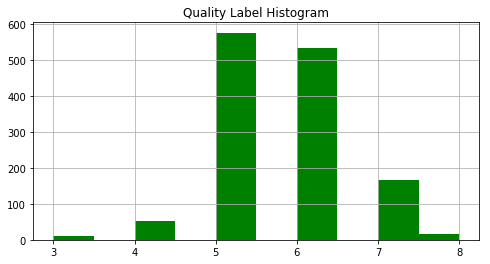

In [12]:
plt.figure()
df['quality'].hist(figsize=(8,4), color='green')
plt.title('Quality Label Histogram')
plt.show()

## Commentary
Most of the data is labelled as 5 or 6.

Very Few examples to train 3,4, or 8.

Will need to mke sure the train / test split is stratified.

### Any clear relationships between Quality and the Features?

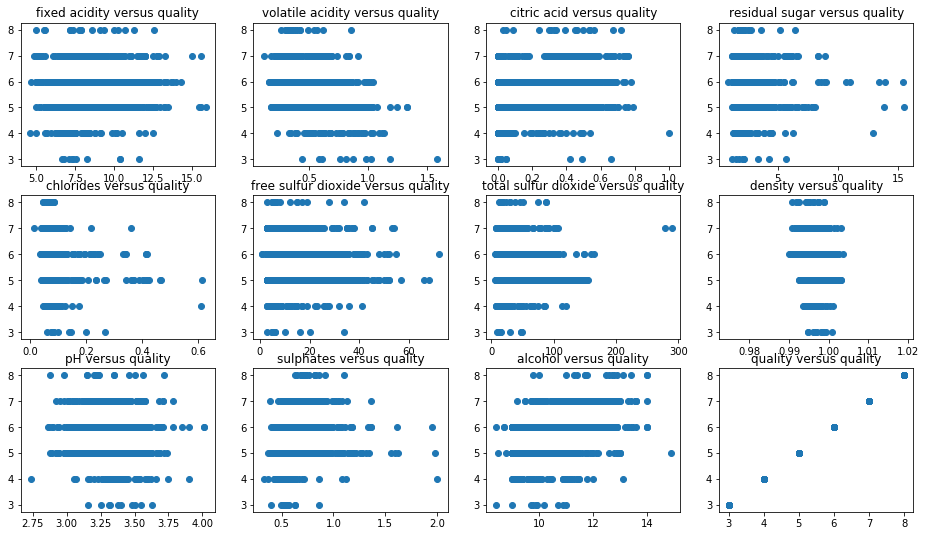

In [13]:
plt.figure(figsize=(16,9))
for j, i in enumerate(df.keys()):
    plt.subplot(3, 4, j+1)
    plt.scatter(df[i],df['quality'])
    plt.title(f'{i} versus quality')
plt.show()

## Or between the features (incl. Quality) ?

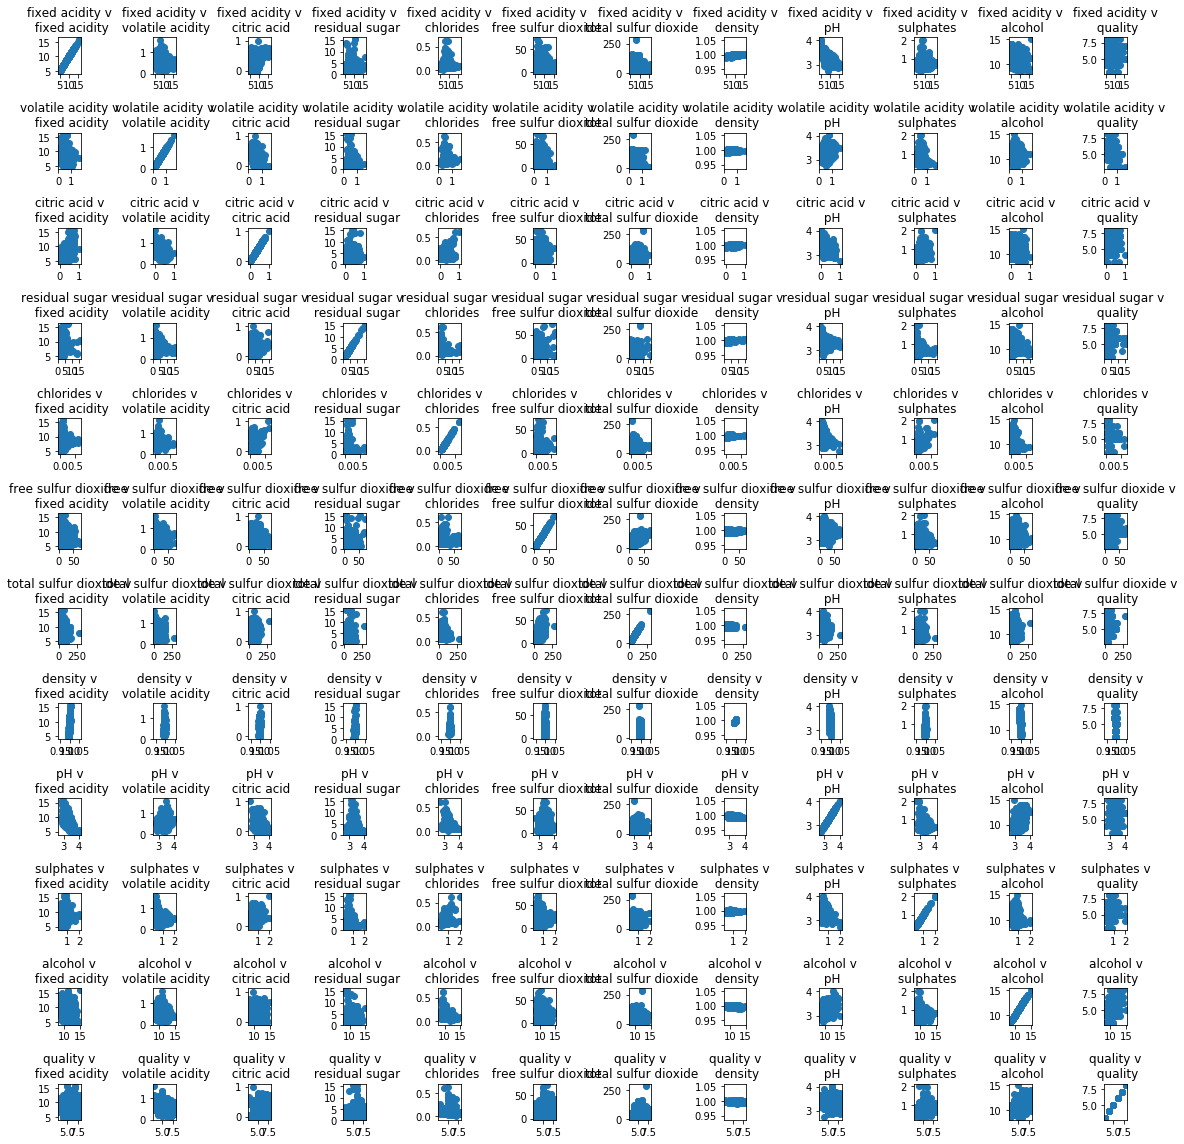

In [14]:
plt.figure(figsize=(16,16))

ind = 1
for i in df.keys():
    for j in df.keys():
        plt.subplot(12, 12, ind)
        plt.scatter(df[i],df[j])
        plt.title(f'{i} v\n {j}')
        ind += 1
#plt.show()
plt.tight_layout()

## Heatmap to more clearly illustrate correlations between features including Quality (the ground truth)

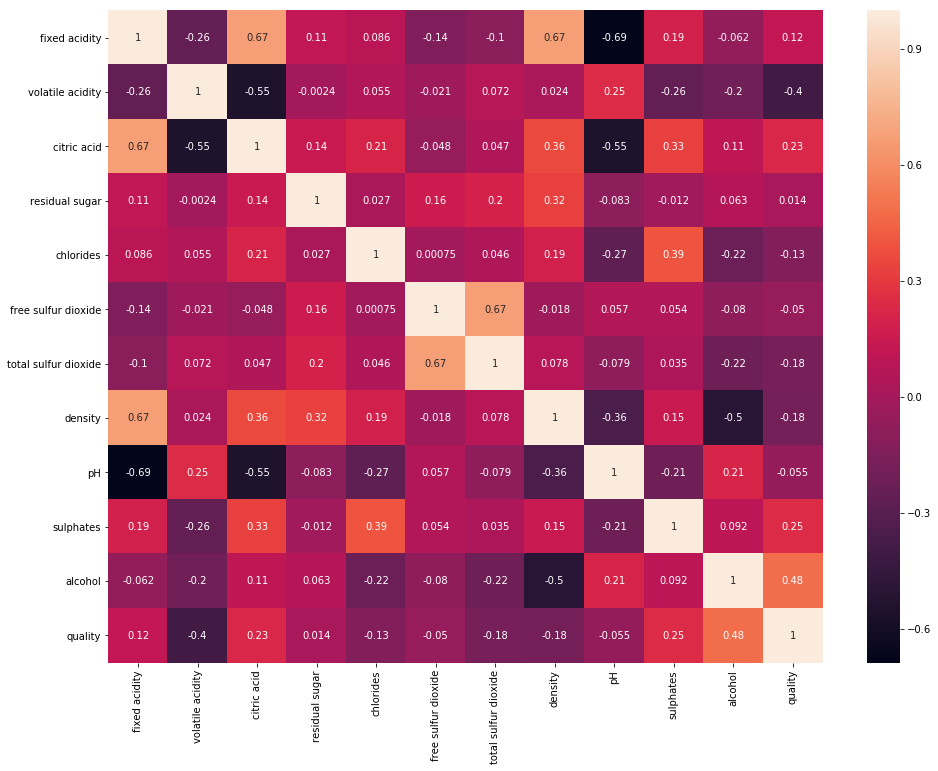

In [15]:
plt.figure(figsize=(16,12))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

## Commentary
* Quality is correlated with Alcohol and Volatile Acidity.
* Alcohol is Correlated with Density.
* Volatile Acidity is correlated with Citric Acid.



## Split data into train and test

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(['quality'], axis=1)   # drop the Label
y = df['quality']

# Stratify due to low numbers of high and low Quality labels
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.33, random_state=42)

In [17]:
# Scale the data to the mean and std of X_train
# We assume X_test would not be available apriori to fit the Scaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)                  # Will use all the data for K-Folds CV


In [18]:
print(X.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1359, 11)
(910, 11)
(910,)
(449, 11)
(449,)


## Boxplots of all features

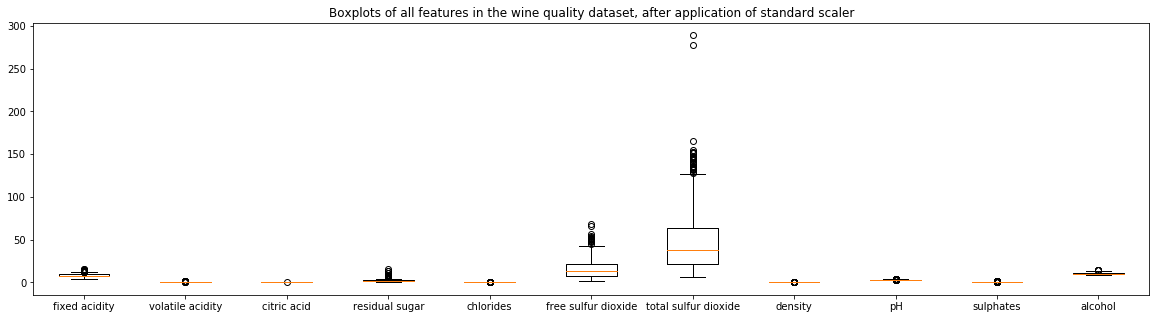

In [19]:
plt.figure(figsize = (20,5))
plt.boxplot([X_train[i] for i in X_train.keys()], labels = X_train.keys())
plt.title("Boxplots of all features in the wine quality dataset, after application of standard scaler")
plt.show()

## Check whether the dataset can be reduced using PCA

In [20]:
from sklearn.decomposition import PCA
skl_pca = PCA()
skl_pca.fit(X_train_scaled)
print("Scikitlearn's principal components are:")
print(skl_pca.explained_variance_ratio_)

Scikitlearn's principal components are:
[0.29099809 0.16748315 0.14351836 0.11065028 0.08458801 0.05669064
 0.05558563 0.03925708 0.03045337 0.01558425 0.00519113]


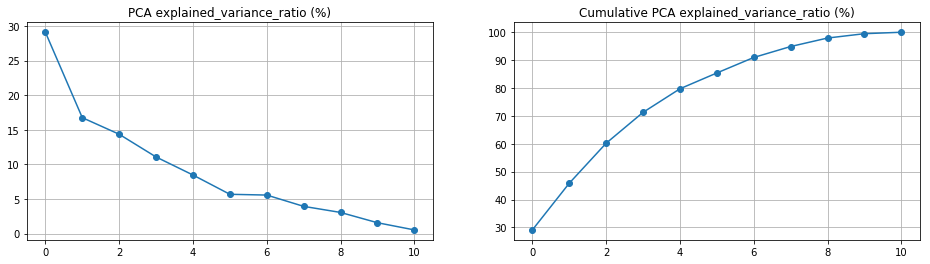

In [21]:
from sklearn.decomposition import PCA

# pca Object
pca = PCA().fit(X_train_scaled)

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.title('PCA explained_variance_ratio (%)')
plt.grid(True)
plt.plot(100*pca.explained_variance_ratio_, marker='o')
plt.subplot(1,2,2)
#plt.axis((0,15,0,100))
plt.title('Cumulative PCA explained_variance_ratio (%)')
plt.grid(True)
plt.plot(100*pca.explained_variance_ratio_.cumsum(), marker='o')
plt.show()


## Commentary
* The shallow tail on the explained_variance_ratio indicates there's little to be gained by reducing features. This is expected because of the lack of strong correlation between featrues as shown in the Correlation Heatmap.

# Decision Tree Classifier
#### Classify on Good versus Bad Quality
* Need a sufficient support from the data frequency for the classification point.
* \>= 6 allows reasonable class frequency and is above mean quality (5.636)

In [22]:
y_class = y >= 6
y_train_class = y_train >= 6
y_test_class = y_test >= 6

### Add Grid search for hyper parameters

In [23]:
clf = DecisionTreeClassifier()
parameters = {'min_samples_split':[2,10,100],
             'max_depth':[2,10,100],
             'min_samples_leaf':[1,10,100]}
clf = GridSearchCV(clf, parameters, cv=3, scoring='accuracy' , verbose=1)
clf.fit(X_scaled, y)   # Use all data because of cv=3

clf.get_params()

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.1s finished


{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': False,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'min_samples_split': [2, 10, 100],
  'max_depth': [

### Use the Grid Searched Optimal Hyper-Parameters to perform Decision Tree Classification
* Use the  'estimator' classifier in the next step

In [24]:
#clf = DecisionTreeClassifier(min_samples_split=100)
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best')

clf = clf.fit(X_train, y_train_class)

y_pred_class = clf.predict(X_test)

print(confusion_matrix(y_test_class, y_pred_class),'\n')

print(classification_report(y_test_class, y_pred_class),'\n')

[[143  68]
 [ 63 175]] 

              precision    recall  f1-score   support

       False       0.69      0.68      0.69       211
        True       0.72      0.74      0.73       238

   micro avg       0.71      0.71      0.71       449
   macro avg       0.71      0.71      0.71       449
weighted avg       0.71      0.71      0.71       449
 



### Commentary
* The confusion matrix represents actual classes in the rows and predicted class in the columns
* We can see that similar misclassification amounts in both classes

In [25]:
from sklearn.tree import export_graphviz

export_graphviz(clf, out_file='tree.dot') #print dotfile

## Decision Tree Graph
#### The top of the Decision Tree gives an insight into how the classification is being made
* 1st : Alcohol > 10.525
* 2nd : Sulphates < 0.585


![title](.\RedWineWebgraphviz.png)